In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

In [2]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

In [3]:
# define the function of new born
fNewBorn(u,uN,p,t)=uN.N(u,t)*p.rBirth

fNewBorn (generic function with 1 method)

In [4]:
# define other functions of flows in this model, since all the other flows' functions have the 
# same form: up_stream stock * rate
# uS: name (symbol) of the upper stream stock
# r: name (symbol) of the parameter rate
function fLinear(uS,r)
    f(u,uN,p,t) = u[uS]*p[r]
    return f
end

fLinear (generic function with 1 method)

# 1. Normoglycemic Population Model

In [5]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
Model_Normoglycemic = StockAndFlow(
    #stocks
    (:NormalWeight=>(:NewBorn,(:DeathNormalWeight,:BecomingOverWeight),(:v_DeathNormalWeight,:v_BecomingOverWeight),:N),
        :OverWeight=>(:BecomingOverWeight,(:DeathOverWeight,:BecomingObese),(:v_DeathOverWeight,:v_BecomingObese),:N),
        :Obese=>(:BecomingObese,:DeathObese,:v_DeathObese,:N)),
   
    #flows
    (:NewBorn=>:v_NewBorn, :DeathNormalWeight=>:v_DeathNormalWeight,:BecomingOverWeight=>:v_BecomingOverWeight,:DeathOverWeight=>:v_DeathOverWeight,
        :BecomingObese=>:v_BecomingObese, :DeathObese=>:v_DeathObese),
    
    #dynamical variables
    (:v_NewBorn=>fNewBorn, :v_DeathNormalWeight=>fLinear(:NormalWeight,:rMortalityWeight), :v_BecomingOverWeight=>fLinear(:NormalWeight,:rOverWeight),
        :v_DeathOverWeight=>fLinear(:OverWeight,:rMortalityWeight),:v_BecomingObese=>fLinear(:OverWeight,:rObese),:v_DeathObese=>fLinear(:Obese,:rMortalityobese)),
    
    #sum dynamical variables
    (:N=>:v_NewBorn)
)

StockAndFlow with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:6, I = 1:3, O = 1:5, V = 1:6, LV = 1:5, LSV = 1:1
┌───┬──────────────┐
│ S │        sname │
├───┼──────────────┤
│ 1 │ NormalWeight │
│ 2 │   OverWeight │
│ 3 │        Obese │
└───┴──────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────────────┐
│ F │ fv │              fname │
├───┼────┼────────────────────┤
│ 1 │  1 │            NewBorn │
│ 2 │  2 │  DeathNormalWeight │
│ 3 │  3 │ BecomingOverWeight │
│ 4 │  4 │    DeathOverWeight │
│ 5 │  5 │      BecomingObese │
│ 6 │  6 │         DeathObese │
└───┴────┴────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  2 │
│ 3 │   5 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  2 │
│ 4 │   5 │  2 │
│ 5 │   6 │  3 │
└───┴─────┴────┘
┌───┬───────────┬──────────────────────┐
│ V │ funcDynam │                vname │
├───┼───────────┼──────────────────────┤
│ 1 │  fNewBorn │            v_NewBorn │
│ 2 │         f │  v_DeathNormalWeight │
│ 3 │         f │ v_BecomingOverWeight │
│ 4 │         f │    v_DeathOverWeight │
│ 5 │         f │      v_BecomingObese │
│ 6 │         f │         v_DeathObese │
└───┴───────────┴──────────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   2 │
│  2 │   1 │   3 │
│  3 │   2 │   4 │
│  4 │   2 │   5 │
│  5 │   3 │   6 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    1 │
└─────┴───────┴──────┘

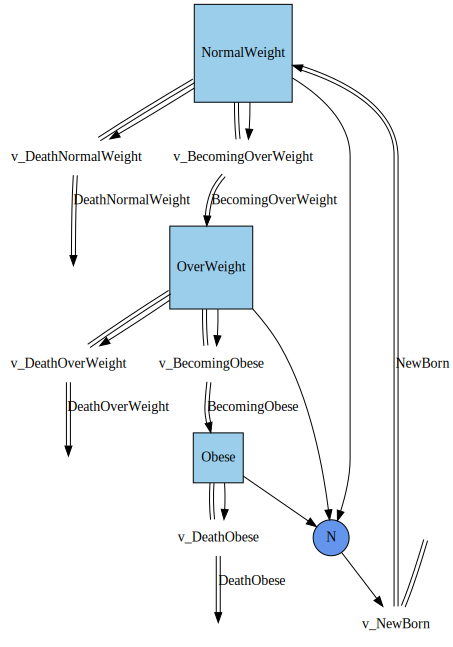

In [6]:
Graph(Model_Normoglycemic, rd="TB")

# 2. Hyperglycemic Population Model
## 2.1 Build Development of Hyperglyce Sub Model Structure

In [30]:
fsymbol(s1,s2)=Symbol(s1*s2)
# pop: string of the sub-population group's name
# function to create a open stock and flow diagram
fOpenSubHyperglycemic(pop) = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (fsymbol("Prediabetic",pop)=>(:F_NONE,(fsymbol("DevelopingDiabetic",pop),fsymbol("DeathPrediabetic",pop)),(fsymbol("v_DevelopingDiabetic",pop),fsymbol("v_DeathPrediabetic",pop)),:N),
        fsymbol("DiabeticWtComp",pop)=>(fsymbol("DevelopingDiabetic",pop),(fsymbol("DevelopingEarly",pop),fsymbol("DeathDiabeticWtComp",pop)),(fsymbol("v_DevelopingEarly",pop),fsymbol("v_DeathDiabeticWtComp",pop)),:N),
        fsymbol("DiabeticEarly",pop)=>(fsymbol("DevelopingEarly",pop),(fsymbol("DevelopingLate",pop),fsymbol("DeathDiabeticEarly",pop)),(fsymbol("v_DevelopingLate",pop),fsymbol("v_DeathDiabeticEarly",pop)),:N),
        fsymbol("DiabeticLate",pop)=>(fsymbol("DevelopingLate",pop),fsymbol("DeathDiabeticLate",pop),fsymbol("v_DeathDiabeticLate",pop),:N)),    
    #flows
    (fsymbol("DevelopingDiabetic",pop)=>fsymbol("v_DevelopingDiabetic",pop), fsymbol("DeathPrediabetic",pop)=>fsymbol("v_DeathPrediabetic",pop),fsymbol("DevelopingEarly",pop)=>fsymbol("v_DevelopingEarly",pop),
        fsymbol("DeathDiabeticWtComp",pop)=>fsymbol("v_DeathDiabeticWtComp",pop), fsymbol("DevelopingLate",pop)=>fsymbol("v_DevelopingLate",pop),fsymbol("DeathDiabeticEarly",pop)=>fsymbol("v_DeathDiabeticEarly",pop),
        fsymbol("DeathDiabeticLate",pop)=>fsymbol("v_DeathDiabeticLate",pop)),           
    #dynamical variables
    (fsymbol("v_DevelopingDiabetic",pop)=>fLinear(fsymbol("Prediabetic",pop),fsymbol("rDevelopingDiabetic",pop)), fsymbol("v_DeathPrediabetic",pop)=>fLinear(fsymbol("Prediabetic",pop),:rMortalityPrediabetic),
        fsymbol("v_DevelopingEarly",pop)=>fLinear(fsymbol("DiabeticWtComp",pop),fsymbol("rDevelopingEarly",pop)), fsymbol("v_DeathDiabeticWtComp",pop)=>fLinear(fsymbol("DiabeticWtComp",pop),fsymbol("rMortalityDiabeticWtComp",pop)),
        fsymbol("v_DevelopingLate",pop)=>fLinear(fsymbol("DiabeticEarly",pop),:rDevelopingLate),fsymbol("v_DeathDiabeticEarly",pop)=>fLinear(fsymbol("DiabeticEarly",pop), fsymbol("rMortalityDiabeticEarly",pop)),
        fsymbol("v_DeathDiabeticLate",pop)=>fLinear(fsymbol("DiabeticLate",pop),:rMortalityDiabeticLate)),    
    #sum dynamical variables
    (:N=>:SVV_NONE) 
    ),
    # feet
    foot(fsymbol("Prediabetic",pop), :N, fsymbol("Prediabetic",pop)=>:N),
    foot(fsymbol("DiabeticWtComp",pop), :N, fsymbol("DiabeticWtComp",pop)=>:N),
    foot(fsymbol("DiabeticEarly",pop), :N, fsymbol("DiabeticEarly",pop)=>:N),
    foot(fsymbol("DiabeticLate",pop), :N, fsymbol("DiabeticLate",pop)=>:N)
)
    

fOpenSubHyperglycemic (generic function with 1 method)

## 2.2 Build Diagnosis of Hyperglyce Sub Model Structure

In [31]:
# function to create a open stock and flow diagram of diagnosis
fOpensubDiagnosis(s) = Open(
    # stock and flow diagram
    StockAndFlow(
    #stocks
    (fsymbol(s,"_U")=>(:F_NONE,fsymbol("Diagnosis",s),fsymbol("v_Diagnosis",s),:N),
        fsymbol(s,"_D")=>(fsymbol("Diagnosis",s),:F_NONE,:V_NONE,:N)),    
    #flows
    (fsymbol("Diagnosis",s)=>fsymbol("v_Diagnosis",s)),           
    #dynamical variables
    (fsymbol("v_Diagnosis",s)=>fLinear(fsymbol(s,"_U"),fsymbol("r",s))),    
    #sum dynamical variables
    (:N=>:SVV_NONE)
    ),
    # feet
    foot(fsymbol(s,"_U"), :N, fsymbol(s,"_U")=>:N),
    foot(fsymbol(s,"_D"), :N, fsymbol(s,"_D")=>:N),
)

fOpensubDiagnosis (generic function with 1 method)

## 2.3 Generate Hyperglycemic Model by Composition

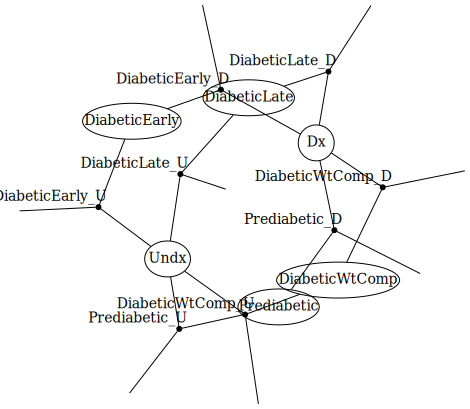

In [32]:
# define the UWD-algebra of Hyperglycemic Model
hyperglycemic_uwd = @relation (Prediabetic_U,Prediabetic_D,DiabeticWtComp_U,DiabeticWtComp_D,DiabeticEarly_U,DiabeticEarly_D,DiabeticLate_U,DiabeticLate_D) begin
    Undx(Prediabetic_U,DiabeticWtComp_U,DiabeticEarly_U,DiabeticLate_U)
    Dx(Prediabetic_D,DiabeticWtComp_D,DiabeticEarly_D,DiabeticLate_D)
    Prediabetic(Prediabetic_U,Prediabetic_D)
    DiabeticWtComp(DiabeticWtComp_U,DiabeticWtComp_D)
    DiabeticEarly(DiabeticEarly_U,DiabeticEarly_D)
    DiabeticLate(DiabeticLate_U,DiabeticLate_D)
end;
display_uwd(hyperglycemic_uwd)

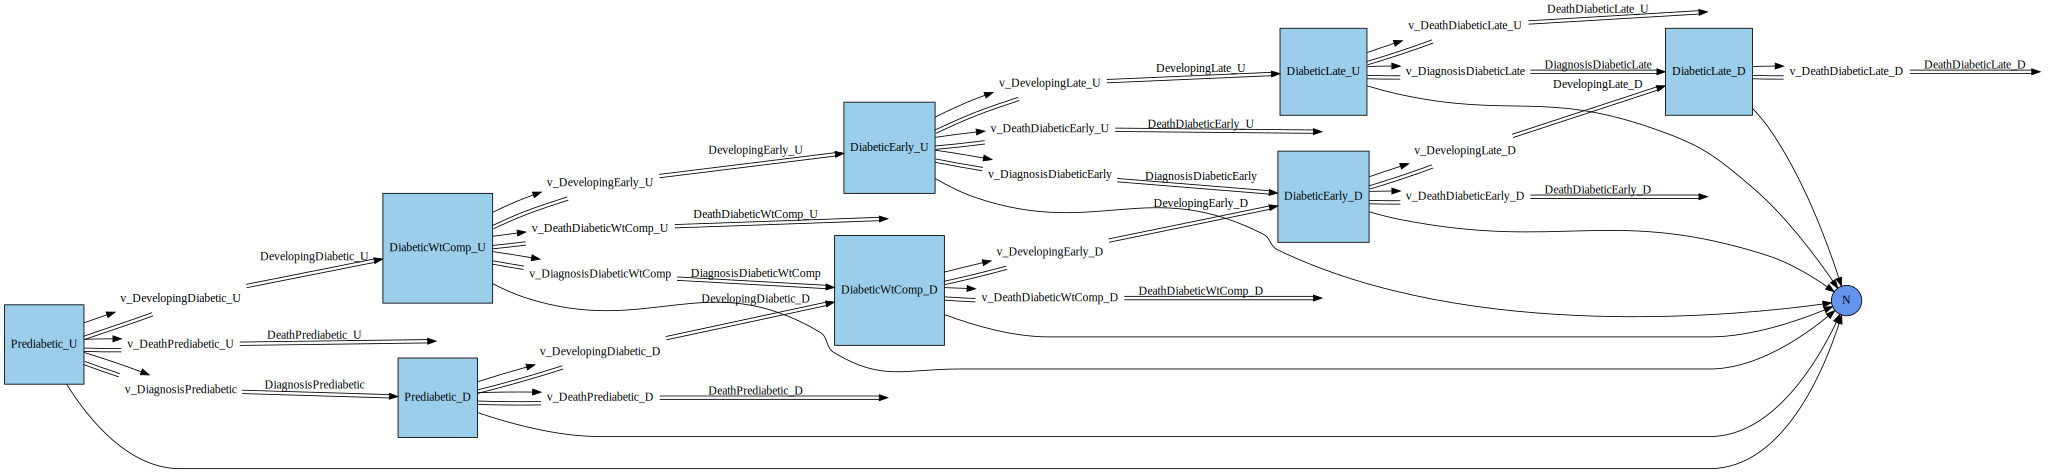

In [33]:
# generate the Hyperglycemic population model by composition
Model_Hyperglycemic=oapply(hyperglycemic_uwd, 
    [fOpenSubHyperglycemic("_U"),fOpenSubHyperglycemic("_D"),fOpensubDiagnosis("Prediabetic"),fOpensubDiagnosis("DiabeticWtComp"),fOpensubDiagnosis("DiabeticEarly"),fOpensubDiagnosis("DiabeticLate")]) |> apex
Graph(Model_Hyperglycemic)

# 3. Connection between Normoglycemic and Hyperglycemic Population Model

In [35]:
Model_Norm_Hyper = StockAndFlow(
    #stocks
    (:NormalWeight=>((:RecoveryToNWFromUx,:RecoveryToNWFromDx),:DevelopingPrediabeticNW,:v_DevelopingPrediabeticNW,:N),
        :OverWeight=>((:RecoveryToOWFromUx,:RecoveryToOWFromDx),:DevelopingPrediabeticOW,:v_DevelopingPrediabeticOW,:N),
        :Obese=>((:RecoveryToOBFromUx,:RecoveryToOBFromDx),:DevelopingPrediabeticOB,:v_DevelopingPrediabeticOB,:N),
        :Prediabetic_U=>((:DevelopingPrediabeticNW,:DevelopingPrediabeticOW,:DevelopingPrediabeticOB),(:RecoveryToNWFromUx,:RecoveryToOWFromUx,:RecoveryToOBFromUx),(:v_RecoveryToNWFromUx,:v_RecoveryToOWFromUx,:v_RecoveryToOBFromUx),:N),
        :Prediabetic_D=>(:F_NONE,(:RecoveryToNWFromDx,:RecoveryToOWFromDx,:RecoveryToOBFromDx),(:v_RecoveryToNWFromDx,:v_RecoveryToOWFromDx,:v_RecoveryToOBFromDx),:N)),    
    #flows
    (:RecoveryToNWFromUx=>:v_RecoveryToNWFromUx, :RecoveryToNWFromDx=>:v_RecoveryToNWFromDx,:DevelopingPrediabeticNW=>:v_DevelopingPrediabeticNW,
        :RecoveryToOWFromUx=>:v_RecoveryToOWFromUx, :RecoveryToOWFromDx=>:v_RecoveryToOWFromDx,:DevelopingPrediabeticOW=>:v_DevelopingPrediabeticOW,
        :RecoveryToOBFromUx=>:v_RecoveryToOBFromUx, :RecoveryToOBFromDx=>:v_RecoveryToOBFromDx,:DevelopingPrediabeticOB=>:v_DevelopingPrediabeticOB),    
    #dynamical variables
    (:v_RecoveryToNWFromUx=>fLinear(:Prediabetic_U,:rRecovery),:v_RecoveryToOWFromUx=>fLinear(:Prediabetic_U,:rRecovery),:v_RecoveryToOBFromUx=>fLinear(:Prediabetic_U,:rRecovery),
     :v_RecoveryToNWFromDx=>fLinear(:Prediabetic_D,:rRecovery),:v_RecoveryToOWFromDx=>fLinear(:Prediabetic_D,:rRecovery),:v_RecoveryToOBFromDx=>fLinear(:Prediabetic_D,:rRecovery),
     :v_DevelopingPrediabeticNW=>fLinear(:NormalWeight,:rIncidenceNW),:v_DevelopingPrediabeticOW=>fLinear(:OverWeight,:rIncidenceOW),:v_DevelopingPrediabeticOB=>fLinear(:Obese,:rIncidenceOB)),    
    #sum dynamical variables
    (:N=>:SVV_NONE)
)

StockAndFlow with elements S = 1:5, SV = 1:1, LS = 1:5, F = 1:9, I = 1:9, O = 1:9, V = 1:9, LV = 1:9, LSV = 1:0
┌───┬───────────────┐
│ S │         sname │
├───┼───────────────┤
│ 1 │  NormalWeight │
│ 2 │    OverWeight │
│ 3 │         Obese │
│ 4 │ Prediabetic_U │
│ 5 │ Prediabetic_D │
└───┴───────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
│  5 │   5 │    1 │
└────┴─────┴──────┘
┌───┬────┬─────────────────────────┐
│ F │ fv │                   fname │
├───┼────┼─────────────────────────┤
│ 1 │  1 │      RecoveryToNWFromUx │
│ 2 │  4 │      RecoveryToNWFromDx │
│ 3 │  7 │ DevelopingPrediabeticNW │
│ 4 │  2 │      RecoveryToOWFromUx │
│ 5 │  5 │      RecoveryToOWFromDx │
│ 6 │  8 │ DevelopingPrediabeticOW │
│ 7 │  3 │      RecoveryToOBFromUx │
│ 8 │  6 │      RecoveryToOBFromDx │
│ 9 │  9 │ DevelopingPrediabeticOB │
└───┴────┴─────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   4 │  2 │
│ 4 │   5 │  2 │
│ 5 │   7 │  3 │
│ 6 │   8 │  3 │
│ 7 │   3 │  4 │
│ 8 │   6 │  4 │
│ 9 │   9 │  4 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   6 │  2 │
│ 3 │   9 │  3 │
│ 4 │   1 │  4 │
│ 5 │   4 │  4 │
│ 6 │   7 │  4 │
│ 7 │   2 │  5 │
│ 8 │   5 │  5 │
│ 9 │   8 │  5 │
└───┴─────┴────┘
┌───┬───────────┬───────────────────────────┐
│ V │ funcDynam │                     vname │
├───┼───────────┼───────────────────────────┤
│ 1 │         f │      v_RecoveryToNWFromUx │
│ 2 │         f │      v_RecoveryToOWFromUx │
│ 3 │         f │      v_RecoveryToOBFromUx │
│ 4 │         f │      v_RecoveryToNWFromDx │
│ 5 │         f │      v_RecoveryToOWFromDx │
│ 6 │         f │      v_RecoveryToOBFromDx │
│ 7 │         f │ v_DevelopingPrediabeticNW │
│ 8 │         f │ v_DevelopingPrediabeticOW │
│ 9 │         f │ v_DevelopingPrediabeticOB │
└───┴───────────┴───────────────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   7 │
│  2 │   2 │   8 │
│  3 │   3 │   9 │
│  4 │   4 │   1 │
│  5 │   4 │   2 │
│  6 │   4 │   3 │
│  7 │   5 │   4 │
│  8 │   5 │   5 │
│  9 │   5 │   6 │
└────┴─────┴─────┘

# 4 Generate Final Diabetes Model by Composition

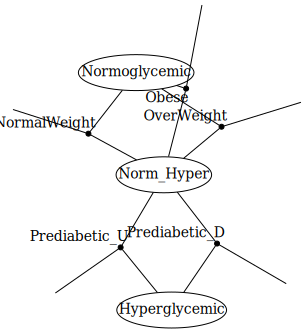

In [36]:
# define the UWD-algebra of Hyperglycemic Model
diabetes_uwd = @relation (NormalWeight,OverWeight,Obese,Prediabetic_U,Prediabetic_D) begin
    Normoglycemic(NormalWeight,OverWeight,Obese)
    Hyperglycemic(Prediabetic_U,Prediabetic_D)
    Norm_Hyper(NormalWeight,OverWeight,Obese,Prediabetic_U,Prediabetic_D)
end;
display_uwd(diabetes_uwd)

In [37]:
Diabetes_Model = oapply(diabetes_uwd,Dict(
    :Normoglycemic=>Open(Model_Normoglycemic,foot(:NormalWeight,:N,:NormalWeight=>:N),foot(:OverWeight,:N,:OverWeight=>:N),foot(:Obese,:N,:Obese=>:N)),
    :Hyperglycemic=>Open(Model_Hyperglycemic,foot(:Prediabetic_U,:N,:Prediabetic_U=>:N),foot(:Prediabetic_D,:N,:Prediabetic_D=>:N)),
    :Norm_Hyper=>Open(Model_Norm_Hyper,foot(:NormalWeight,:N,:NormalWeight=>:N),foot(:OverWeight,:N,:OverWeight=>:N),foot(:Obese,:N,:Obese=>:N),foot(:Prediabetic_U,:N,:Prediabetic_U=>:N),foot(:Prediabetic_D,:N,:Prediabetic_D=>:N))    
    )) |> apex

S,sname
1,NormalWeight
2,OverWeight
3,Obese
4,Prediabetic_U
5,DiabeticWtComp_U
6,DiabeticEarly_U
7,DiabeticLate_U
8,Prediabetic_D
9,DiabeticWtComp_D
10,DiabeticEarly_D


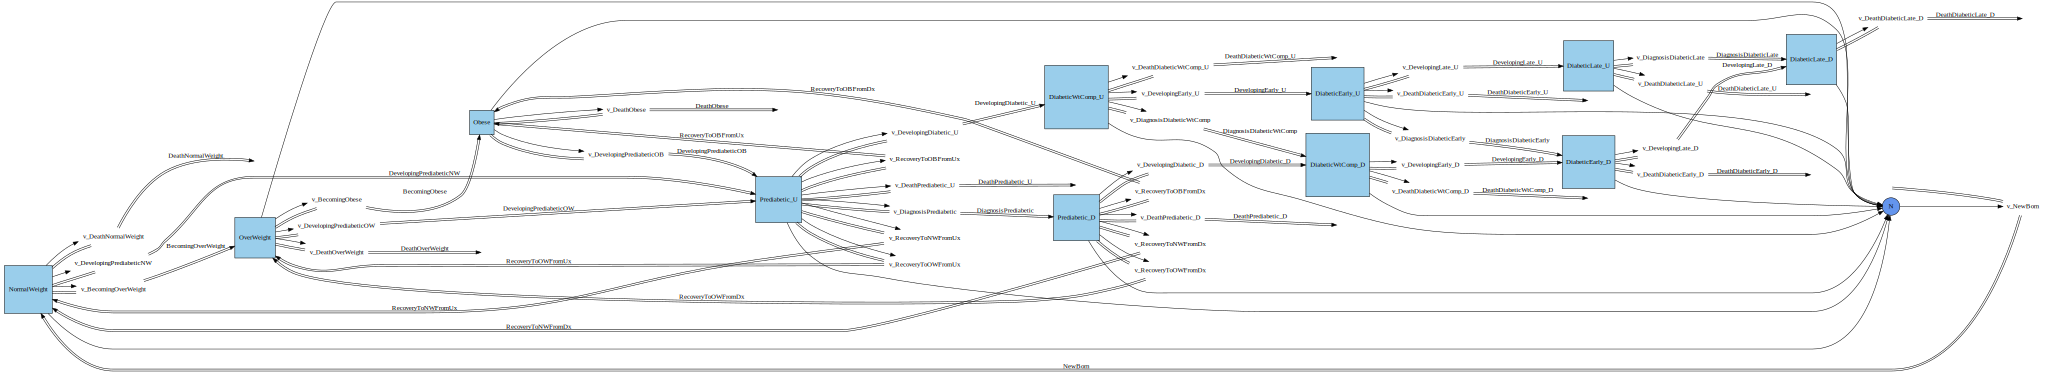

In [38]:
Graph(Diabetes_Model)

In [39]:
p = LVector(
    rBirth=12.5/1000, rMortalityWeight=4.0/1000, rOverWeight=0.03, rObese=0.06, rMortalityobese=13.0/1000,
    rDevelopingDiabetic_U=1.0/10.0, rDevelopingDiabetic_D=1.0/15.0, rMortalityPrediabetic=13.0/1000,
    rDevelopingEarly_U=1.0/10.0, rDevelopingEarly_D=1.0/15.0, rMortalityDiabeticWtComp_U=0.03, rMortalityDiabeticWtComp_D=0.027,
    rDevelopingLate=0.9, rMortalityDiabeticEarly_U=0.04+0.02, rMortalityDiabeticEarly_D=0.036+0.02,rMortalityDiabeticLate=0.04,
    rPrediabetic=0.1, rDiabeticWtComp=0.24, rDiabeticEarly=0.4, rDiabeticLate=0.6, rRecovery=0.03,
    rIncidenceNW=0.01, rIncidenceOW=0.017, rIncidenceOB=0.026
)
u0 = LVector(
    NormalWeight=95811.0, OverWeight=27709.0, Obese=30770.0, Prediabetic_U=13615.0, Prediabetic_D=2000.0,
    DiabeticWtComp_U=6396.0, DiabeticWtComp_D=3000.0, DiabeticEarly_U=0.0, DiabeticEarly_D=1200.0,
    DiabeticLate_U=0.0, DiabeticLate_D=800.0 
)

8-element LArray{Float64, 1, Vector{Float64}, (:Prediabetic_U, :Prediabetic_D, :DiabeticWtComp_U, :DiabeticWtComp_D, :DiabeticEarly_U, :DiabeticEarly_D, :DiabeticLate_U, :DiabeticLate_D)}:
    :Prediabetic_U => 13615.0
    :Prediabetic_D => 2000.0
 :DiabeticWtComp_U => 6396.0
 :DiabeticWtComp_D => 3000.0
  :DiabeticEarly_U => 0.0
  :DiabeticEarly_D => 1200.0
   :DiabeticLate_U => 0.0
   :DiabeticLate_D => 800.0

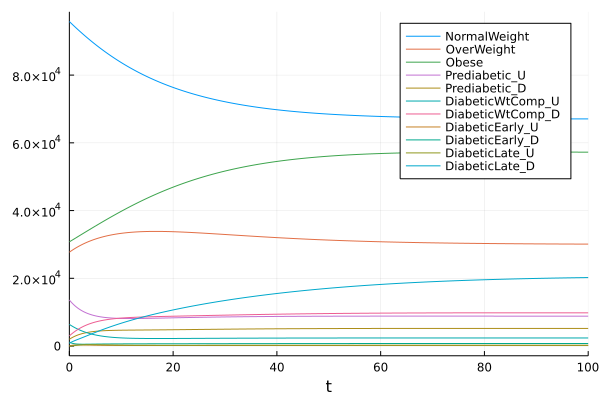

In [40]:
# results have been tested correct (same as the Anylogic model)
prob_diabetes = ODEProblem(vectorfield(Diabetes_Model),u0,(0.0,100.0),p);
sol_diabetes = solve(prob_diabetes,Tsit5(),abstol=1e-8);
plot(sol_diabetes)